In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [52]:
import glob
import pandas as pd
import numpy as np
import random
import pickle
from tsfeatures import tsfeatures
import matplotlib.pyplot as plt
import plotly.express as px

# K-mean clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm import tqdm

In [26]:
# Read the features from the csv file
features = pd.read_csv('data/social_features.csv', index_col=0)
features

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h22,h23,w0,w1,w2,w3,w4,w5,w6,yearly
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.031726,0.029920,0.153507,0.153666,0.152658,0.154355,0.148051,0.133553,0.104211,318302.80
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.046429,0.042130,0.151293,0.145897,0.159202,0.132258,0.147747,0.142086,0.121517,153689.35
279,0.035217,0.035691,0.035924,0.036774,0.037489,0.038917,0.041253,0.053402,0.061577,0.060797,...,0.034366,0.034535,0.157889,0.151745,0.150138,0.154060,0.151909,0.116794,0.117466,183892.35
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.017136,0.017330,0.191259,0.191926,0.137312,0.184640,0.189721,0.053119,0.052023,162680.06
510,0.014744,0.007901,0.004330,0.004037,0.006856,0.011406,0.013673,0.029621,0.062467,0.072689,...,0.030923,0.022377,0.136561,0.140826,0.168097,0.167481,0.148380,0.123754,0.114900,37180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.042156,0.037928,0.143109,0.145693,0.145230,0.146309,0.148926,0.140697,0.130036,235928.75
642,0.015514,0.015802,0.016082,0.016216,0.017069,0.020507,0.026651,0.037020,0.061349,0.077849,...,0.021696,0.015323,0.168094,0.193132,0.170394,0.180394,0.157494,0.078155,0.052337,454916.00
597,0.038067,0.037521,0.036766,0.036398,0.036318,0.037213,0.039300,0.042130,0.044671,0.046686,...,0.038328,0.038213,0.150509,0.150686,0.150042,0.150256,0.149876,0.125190,0.123440,3033266.00
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.028453,0.028313,0.162106,0.183607,0.189405,0.171302,0.132398,0.082819,0.078364,193245.40


In [27]:
# read metadata csv
metadata = pd.read_csv('data/EANLIJST_METADATA.csv', index_col=0, sep   = ';')
# ADD the functietype column to the features
features['function'] = metadata['Patrimonium Functietype']
# read more metrics from csv
metrics = pd.read_csv('data/ts_metrics.csv', usecols = ['ID', 'mean', 'std'], index_col='ID')
# add the metrics to the features
features = features.join(metrics)
features.isnull().sum()
features.dropna(inplace=True)
features['ID'] = features.index
# drop rows with kast as function
features = features[features['function'] != 'Kast']
features

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,w2,w3,w4,w5,w6,yearly,function,mean,std,ID
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.152658,0.154355,0.148051,0.133553,0.104211,318302.80,Stadhuis/Gemeentehuis,9.313439,3.516002,1208
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.159202,0.132258,0.147747,0.142086,0.121517,153689.35,Academie,4.929265,4.023414,588
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.137312,0.184640,0.189721,0.053119,0.052023,162680.06,Lagere school,4.773989,4.691106,144
510,0.014744,0.007901,0.004330,0.004037,0.006856,0.011406,0.013673,0.029621,0.062467,0.072689,...,0.168097,0.167481,0.148380,0.123754,0.114900,37180.00,Andere gebouwen,1.146714,3.083926,510
220,0.040849,0.039825,0.039646,0.039548,0.039077,0.039167,0.040639,0.040169,0.040585,0.042644,...,0.130644,0.138710,0.146308,0.162578,0.158316,11984.11,Ontmoetingscentrum,0.370451,0.813041,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.024128,0.023211,0.022013,0.021805,0.025018,0.024900,0.026935,0.038310,0.047993,0.052065,...,0.156163,0.135576,0.147289,0.156389,0.120595,125351.45,Ontmoetingscentrum,4.722174,3.758550,56
13,0.025005,0.024656,0.024338,0.024243,0.024247,0.026615,0.032917,0.043306,0.056842,0.062189,...,0.164159,0.161534,0.133354,0.102400,0.100667,364743.85,Administratief centrum,10.530915,5.580256,13
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.145230,0.146309,0.148926,0.140697,0.130036,235928.75,Cultureel centrum,7.875420,4.729058,1660
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.189405,0.171302,0.132398,0.082819,0.078364,193245.40,Werkplaats,5.620527,4.201984,235


In [23]:
components

array([[-3.91004233e-02],
       [ 3.63656253e-01],
       [ 3.13958211e+00],
       [ 1.25363892e+00],
       [-1.91379928e+00],
       [-1.24274529e+00],
       [ 4.01230641e-01],
       [ 3.23242503e-01],
       [-1.14531677e-01],
       [ 5.17222311e+00],
       [-1.35949622e+00],
       [ 2.00104752e-01],
       [-7.62934565e-01],
       [ 5.08732065e-01],
       [ 8.38000646e-01],
       [-1.74544645e+00],
       [ 1.79735679e+00],
       [-3.53179781e-01],
       [ 6.49777378e-01],
       [ 2.17149599e-01],
       [-3.15316998e+00],
       [ 3.79992577e-02],
       [ 1.36914583e+00],
       [ 1.64084538e-01],
       [-1.37435817e+00],
       [-1.49827197e+00],
       [-3.23495000e-01],
       [-6.52445938e-01],
       [ 3.16211910e-01],
       [-7.81346155e-01],
       [-9.33676926e-01],
       [ 7.69205170e-01],
       [ 9.23829848e-01],
       [-8.19784452e-02],
       [ 8.62491983e-01],
       [ 6.00141075e-01],
       [-7.30633763e-01],
       [-1.23563805e+00],
       [ 1.0

In [51]:
clust_num = 4
subset = features.drop(['function', 'ID', 'mean', 'std', 'yearly'], axis=1).copy()
# K-mean clustering on the features dataset
kmeans = KMeans(n_clusters=clust_num, random_state=2).fit(subset)
# kmeans save model
pickle.dump(kmeans, open("kmeans{}.pkl".format(clust_num), "wb"))
clusters = kmeans.labels_
# Create two axis with PCA
pca = PCA(n_components=1)
components = subset['w5'] + subset['w6']
labels = {}
labels[0] = 'weekend'
pca = PCA(n_components=1)
components = np.c_[components, subset[['h18', 'h19', 'h20', 'h21', 'h22']].sum(axis=1)]
# add to labels
labels[1] = 'evening'
scat = subset.join(pd.DataFrame(components, index=features.index, columns=list(labels.values())))
scat['ID'] = scat.index
scat['cluster'] = clusters
scat['function'] = features['function']
scat['mean'] = features['mean']
scat['std'] = features['std']
scat

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,w4,w5,w6,weekend,evening,ID,cluster,function,mean,std
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.148051,0.133553,0.104211,0.237764,0.186395,1208,1,Stadhuis/Gemeentehuis,9.313439,3.516002
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.147747,0.142086,0.121517,0.263603,0.259632,588,1,Academie,4.929265,4.023414
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.189721,0.053119,0.052023,0.105142,0.097103,144,3,Lagere school,4.773989,4.691106
510,0.014744,0.007901,0.004330,0.004037,0.006856,0.011406,0.013673,0.029621,0.062467,0.072689,...,0.148380,0.123754,0.114900,0.238654,0.284621,510,1,Andere gebouwen,1.146714,3.083926
220,0.040849,0.039825,0.039646,0.039548,0.039077,0.039167,0.040639,0.040169,0.040585,0.042644,...,0.146308,0.162578,0.158316,0.320895,0.207712,220,1,Ontmoetingscentrum,0.370451,0.813041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.024128,0.023211,0.022013,0.021805,0.025018,0.024900,0.026935,0.038310,0.047993,0.052065,...,0.147289,0.156389,0.120595,0.276985,0.204255,56,1,Ontmoetingscentrum,4.722174,3.758550
13,0.025005,0.024656,0.024338,0.024243,0.024247,0.026615,0.032917,0.043306,0.056842,0.062189,...,0.133354,0.102400,0.100667,0.203067,0.199861,13,3,Administratief centrum,10.530915,5.580256
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.148926,0.140697,0.130036,0.270733,0.233330,1660,1,Cultureel centrum,7.875420,4.729058
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.132398,0.082819,0.078364,0.161183,0.135206,235,3,Werkplaats,5.620527,4.201984


In [29]:
fig = px.scatter(scat, x=list(labels.values())[0], y=list(labels.values())[1], color='cluster', hover_name=features.function, hover_data=features[['ID', 'mean', 'std']])
fig.update_traces(mode="markers")   
fig.show()

In [32]:
# Show  value counts in the function column for each cluster
counts = scat.groupby('cluster').function.value_counts().sort_values(ascending=False).unstack().T
counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

cluster,0,1,2,3
function,,,,
Sporthal,NaN,82.0,9.0,15.0
Andere gebouwen,21.0,48.0,7.0,12.0
Administratief centrum,2.0,29.0,NaN,54.0
Cultureel centrum,2.0,59.0,NaN,11.0
Ontmoetingscentrum,5.0,55.0,1.0,6.0
Lagere school,NaN,3.0,NaN,53.0
Stadhuis/Gemeentehuis,NaN,14.0,NaN,27.0
RVT/WZC/revalidatiecentrum,NaN,36.0,NaN,5.0
Werkplaats,NaN,9.0,NaN,20.0


In [38]:
day_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(scat[scat.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # drop the rows with any infinite values
    agg = agg[~np.isinf(agg).any(1)]
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    # group by hour of the day and make an average
    agg = agg.groupby(agg.index.hour).mean()
    day_p[clust] = agg

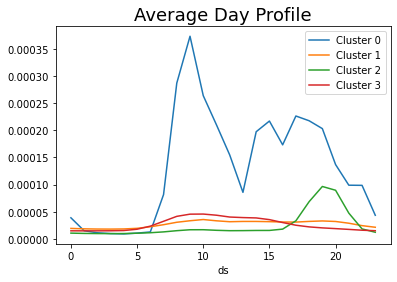

In [45]:
day_p.columns = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3']
day_p.plot()
plt.title('Average Day Profile', fontsize=18)
plt.show()

In [46]:
weekly_p = pd.DataFrame(columns = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'])
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(scat[scat.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # drop the rows with any infinite values
    agg = agg[~np.isinf(agg).any(1)]
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    # group by day of the week and take and average
    agg = agg.groupby(agg.index.weekday).mean()

In [ ]:
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(scat[scat.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # Create an average profile over columns
    agg = agg.mean(axis=1)